In [12]:
import os
import torch
from torch.utils.data import DataLoader
from model_paired_ae_emma import MultimodalAE, Encoder, Decoder
from src.dataset import generate_datasets, concat_datasets
import torch.nn as nn

In [13]:
concat_datasets(root_dir='./data', suffix='diff')

false
true
true
false
true
true
false
true
true
false
true
true


'Concatenated paired datasets : Done'

### Data

In [14]:
# Génération des ensembles de données
train_datasets = generate_datasets(suffix='all_diff', type='paired', train=True, test=False)
test_datasets = generate_datasets(suffix='all_diff', type='paired', train=False, test=True)


# Création des chargeurs de données
train_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in train_datasets]
test_loaders = [DataLoader(dataset, batch_size=32, shuffle=False) for dataset in test_datasets]


# Obtenez les dimensions d'entrée à partir des ensembles de données
n_inputs1 = train_datasets[0][0][0].shape[0]  # La taille du vecteur de caractéristiques pour la modalité 1
n_inputs2 = train_datasets[1][0][0].shape[0]  # La taille du vecteur de caractéristiques pour la modalité 2
n_inputs3 = train_datasets[2][0][0].shape[0]  # La taille du vecteur de caractéristiques pour la modalité 3

Loading paired dataset
Loading paired dataset


### Initialisation des modèles

In [15]:
latent_dims = 20   
n_hiddens = 256

# Création du modèle
encoder1 = Encoder(n_inputs1, latent_dims, n_hiddens)
encoder2 = Encoder(n_inputs2, latent_dims, n_hiddens)
encoder3 = Encoder(n_inputs3, latent_dims, n_hiddens)

z1 = encoder1(train_datasets[0][0][0])
z2 = encoder2(train_datasets[1][0][0])
z3 = encoder3(train_datasets[2][0][0])

decoder1 = Decoder(n_inputs1, latent_dims, n_hiddens)
decoder2 = Decoder(n_inputs2, latent_dims, n_hiddens)
decoder3 = Decoder(n_inputs3, latent_dims, n_hiddens)

model1 = MultimodalAE(encoder=encoder1, decoder=decoder1)
model2 = MultimodalAE(encoder=encoder2, decoder=decoder2)
model1_2 = MultimodalAE(encoder=encoder1, decoder=decoder2)
model2_1 = MultimodalAE(encoder=encoder2, decoder=decoder1)
model3 = MultimodalAE(encoder=encoder3, decoder=decoder3)
model1_3 = MultimodalAE(encoder=encoder1, decoder=decoder3)
model3_1 = MultimodalAE(encoder=encoder3, decoder=decoder1)
model2_3 = MultimodalAE(encoder=encoder2, decoder=decoder3)
model3_2 = MultimodalAE(encoder=encoder3, decoder=decoder2)

### Critère et optimiseur

In [16]:
critere = nn.MSELoss()
lr = 0.001
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
optimizer1_2 = torch.optim.Adam(model1_2.parameters(), lr=lr)
optimizer2_1 = torch.optim.Adam(model2_1.parameters(), lr=lr)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=lr)
optimizer1_3 = torch.optim.Adam(model1_3.parameters(), lr=lr)
optimizer3_1 = torch.optim.Adam(model3_1.parameters(), lr=lr)

### Train

In [38]:
num_epochs = 100
batch_size = 32
list1_1 = []
list3_3 = []
list1_3 = []
list3_1 = []

for epoch in range(num_epochs):
    model1.train()
    model3.train()
    model1_3.train()
    model3_1.train()
    
    for i, ((x1, _), (x2, _), (x3, y)) in enumerate(zip(*train_loaders)):
        if x1.size(0) != batch_size or x3.size(0) != batch_size or y.size(0) != batch_size:
            continue
        
        # Forward pass
        o1, o3, o1_3, o3_1 = model1(x1), model3(x3), model1_3(x1), model3_1(x3)
        loss1_1, loss3_3, loss1_3, loss3_1 = critere(o1, x1), critere(o3, x3), critere(o1_3, x3), critere(o3_1, x1)
        
        # Compute total loss
        loss = loss1_1 + loss3_3 + 0*loss1_3 + 0*loss3_1
        
        # Backward and optimize
        optimizer1.zero_grad()
        optimizer3.zero_grad()
        # optimizer1_3.zero_grad()
        # optimizer3_1.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer3.step()
        # optimizer1_3.step()
        # optimizer3_1.step()

    list1_1.append(loss1_1.item())
    list3_3.append(loss3_3.item())
    list1_3.append(loss1_3.item())
    list3_1.append(loss3_1.item())
    
    # Print epoch-wise losses
    print(f'Epoch {epoch + 1} -> Total Loss: {loss:.4f}')

Epoch 1 -> Total Loss: 0.2774
Epoch 2 -> Total Loss: 0.1565
Epoch 3 -> Total Loss: 0.1287
Epoch 4 -> Total Loss: 0.1225
Epoch 5 -> Total Loss: 0.1218
Epoch 6 -> Total Loss: 0.1057
Epoch 7 -> Total Loss: 0.1038
Epoch 8 -> Total Loss: 0.1069
Epoch 9 -> Total Loss: 0.1033
Epoch 10 -> Total Loss: 0.0971
Epoch 11 -> Total Loss: 0.0989
Epoch 12 -> Total Loss: 0.0868
Epoch 13 -> Total Loss: 0.0947
Epoch 14 -> Total Loss: 0.0923
Epoch 15 -> Total Loss: 0.0809
Epoch 16 -> Total Loss: 0.0802
Epoch 17 -> Total Loss: 0.0846
Epoch 18 -> Total Loss: 0.0816
Epoch 19 -> Total Loss: 0.0808
Epoch 20 -> Total Loss: 0.0835
Epoch 21 -> Total Loss: 0.0849
Epoch 22 -> Total Loss: 0.0753
Epoch 23 -> Total Loss: 0.0835
Epoch 24 -> Total Loss: 0.0796
Epoch 25 -> Total Loss: 0.0779
Epoch 26 -> Total Loss: 0.0765
Epoch 27 -> Total Loss: 0.0773
Epoch 28 -> Total Loss: 0.0775
Epoch 29 -> Total Loss: 0.0764
Epoch 30 -> Total Loss: 0.0731
Epoch 31 -> Total Loss: 0.0762
Epoch 32 -> Total Loss: 0.0851
Epoch 33 -> Total

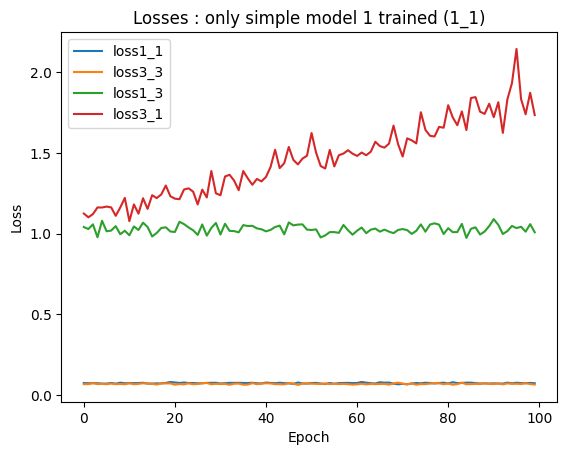

In [37]:
import matplotlib.pyplot as plt

plt.plot(list1_1, label='loss1_1')
plt.plot(list3_3, label='loss3_3')
plt.plot(list1_3, label='loss1_3')
plt.plot(list3_1, label='loss3_1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses : only simple model 3 trained (3_3)')
plt.legend()

### Test

In [10]:
model1.eval()
model3.eval()
model1_3.eval()
model3_1.eval()

with torch.no_grad():
    total_loss = 0
    for (x1, _), (x2, _), (x3, y) in zip(*test_loaders):
        o1, o3, o1_3, o3_1 = model1(x1), model3(x3), model1_3(x1), model3_1(x3)
        loss = critere(o1, x1) + critere(o3, x3) + critere(o1_3, x3) + critere(o3_1, x1)
        total_loss += loss.item()
    print(f'Test Loss: {total_loss / len(test_loaders[0])}')
    print(" loss1 :", critere(o1, x1).item(), " loss3 :", critere(o3, x3).item(), " loss1_3 :", critere(o1_3, x3).item(), " loss3_1 :", critere(o3_1, x1).item())

Test Loss: 2.2952415566695366
 loss1 : 0.2092171162366867  loss3 : 0.08865409344434738  loss1_3 : 0.9565213322639465  loss3_1 : 0.9690064787864685


# Autre tentative : avec décodeurs déjà entaînés

### Initialisation des modèles

In [ ]:
# Création du modèle
encoder1_new = Encoder(n_inputs1, latent_dims, n_hiddens)
encoder3_new = Encoder(n_inputs3, latent_dims, n_hiddens)

decoder1_new = decoder1.clone()

model1_new = MultimodalAE(encoder=encoder1_new, decoder=decoder1_new)
model3_1_new = MultimodalAE(encoder=encoder3_new, decoder=decoder1_new)

In [ ]:
critere = nn.MSELoss()
lr = 0.001
optimizer1_new = torch.optim.Adam(model1_new.parameters(), lr=lr)
optimizer3_1_new = torch.optim.Adam(model3_1_new.parameters(), lr=lr)

In [ ]:
num_epochs = 100
batch_size = 32
list1_1 = []
list3_1 = []

for epoch in range(num_epochs):
    model1_new.train()
    model3_1_new.train()
    
    running_loss = 0.0
    
    for i, ((x1, _), (x2, _), (x3, y)) in enumerate(zip(*train_loaders)):
        if x1.size(0) != batch_size or x3.size(0) != batch_size or y.size(0) != batch_size:
            continue
        
        # Forward pass
        o1, o3, o1_3, o3_1 = model1(x1), model3(x3), model1_3(x1), model3_1(x3)
        loss1_1, loss3_3, loss1_3, loss3_1 = critere(o1, x1), critere(o3, x3), critere(o1_3, x3), critere(o3_1, x1)
        
        # Compute total loss
        loss = loss1_1 + loss3_3 + 0*loss1_3 + 0*loss3_1
        
        # Backward and optimize
        optimizer1.zero_grad()
        optimizer3.zero_grad()
        # optimizer1_3.zero_grad()
        # optimizer3_1.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer3.step()
        # optimizer1_3.step()
        # optimizer3_1.step()

    list1_1.append(loss1_1.item())
    list3_3.append(loss3_3.item())
    list1_3.append(loss1_3.item())
    list3_1.append(loss3_1.item())
    
    # Print epoch-wise losses
    print(f'Epoch {epoch + 1} -> Total Loss: {loss:.4f}')